In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from scipy import stats
import math
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import savgol_filter
from bar_funcs import *

Unable to import [unsiotools.py_unstools]....


In [16]:
plt.rc('text', usetex=True)
plt.rcParams['font.size'] = 15

In [17]:
#caminhos galáxia + satélite
path_01_10 = 'satelites/sat01-10/'
path_01_20 = 'satelites/sat01-20/'
path_01_30 = 'satelites/sat01-30/'
path_05_10 = 'satelites/sat05-10/'
path_05_20 = 'satelites/sat05-20/'
path_05_30 = 'satelites/sat05-30/'
path_1_10 = 'satelites/sat1-10/'
path_1_20 = 'satelites/sat1-20/'
path_1_30 = 'satelites/sat1-30/'

path_b = 'barrada/'

In [18]:
n_snapshots = 121
n_snapshots_ = 281

In [19]:
%%time

amplitude = []
time = []

for j in range (0, n_snapshots_,2): 
    index = str(j).zfill(3)
    snapshot = path_b + f'snapshot_{index}.hdf5'

    #ler snapshot
    f = h5py.File(snapshot, 'r')

    time.append(round(f['Header'].attrs['Time'], 2)+ 8.0)
    
    f_disk = f['PartType2']
    
    x_disk = np.array(f_disk['Coordinates'][:,0])
    y_disk = np.array(f_disk['Coordinates'][:,1])
    z_disk = np.array(f_disk['Coordinates'][:,2])
    vx_disk = np.array(f_disk['Velocities'][:,0])
    vy_disk = np.array(f_disk['Velocities'][:,1])
    vz_disk = np.array(f_disk['Velocities'][:,2])
    m_disk = np.array(f_disk['Masses'])
    Ndisk = len(np.array(f_disk['ParticleIDs'])) 
    
    #corrigir posição - centro de massa - disk
    x_new_disk, y_new_disk, z_new_disk = shift_com(m_disk, x_disk, y_disk, z_disk)
    vx_new_disk, vy_new_disk, vz_new_disk = shift_com(m_disk, vx_disk, vy_disk, vz_disk)
            
    #corrigir posição - momento angular - disk
    theta, phi = theta_phi(N=Ndisk, x=x_new_disk, y=y_new_disk, z=z_new_disk, vx=vx_new_disk,
                                       vy=vy_new_disk, vz=vz_new_disk, m=m_disk)
    x, y, vx, vy = angular_momentum_1(N=Ndisk, x=x_new_disk, y=y_new_disk, vx=vx_new_disk,
                                                  vy=vy_new_disk, theta=theta)
    x, z, vx, vz = angular_momentum_2(N=Ndisk, x=x, z=z_new_disk, vx=vx, vz=vz_new_disk, phi=phi)

    #cálculo z(theta)
    Theta_ = []
    Z_ = []
    
    r = sqrt(x**2 + y**2)
    rmin = 20.0
    rmax = 35.0
    theta_disk = np.arctan2(y, x)
                
    theta_min = (-1) * np.pi
    theta_max = np.pi
    Nbins = 30
    dtheta = (theta_max - theta_min)/Nbins
                
    for i in range(-Nbins, Nbins):
        theta1 = i * dtheta
        theta2 = theta1 + dtheta
        Theta_.append((theta1 + theta2) * 0.5)
        cond = argwhere((theta_disk>theta1) & (theta_disk<theta2) & (r>rmin) & (r<rmax)).flatten()
        zmean = mean(z[cond])
        Z_.append(zmean)

    #amplitude
    for i in range (0, 60):
    	if math.isnan(Z_[i]) == True:
    		Z_[i] = 0

    ampmax = np.max(Z_)
    ampmin = abs(np.min(Z_))
    amplitude.append((ampmax + ampmin)/2)

    out = transpose([amplitude, time]) 
    name = 'amp-b.txt'
    savetxt(name, out, fmt='%1.6e')
    
    #figura
    # plt.figure(figsize=[6,6])
    # plt.plot(Theta_, Z_, 'k.')
    # xlims=[(-1) * np.pi, np.pi]
    # plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$+\pi/2$', r'$+\pi$'])
    # plt.xlim(xlims)
    # ylims=[-6, 6]
    # plt.ylim(ylims)   
    # plt.xlabel(r'$\theta~$')
    # plt.ylabel(r'$\bar{z}~({\rm kpc})$')
    # plt.title(f'Time = {time} Gyr')
    # plt.tight_layout()
    #plt.savefig(f'z-theta-{time}.png')

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


CPU times: user 38min 46s, sys: 54.3 s, total: 39min 40s
Wall time: 39min 9s


In [20]:
doc = 'amp-b.txt'
amplitude, time = loadtxt(doc, usecols=(0,1), unpack=True)

In [24]:
time_= time - 8

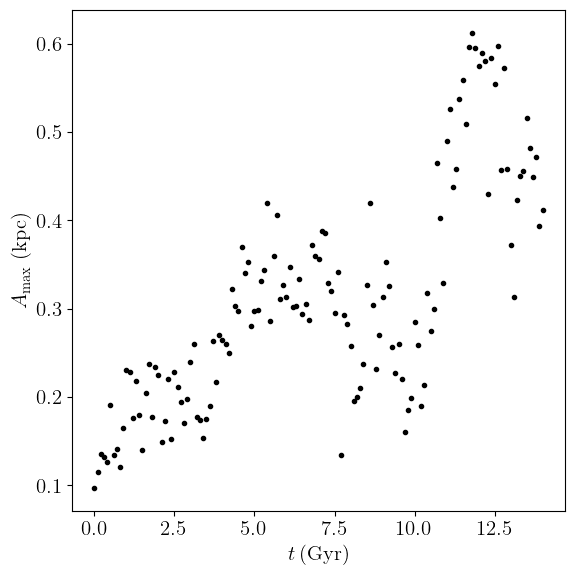

In [25]:
plt.figure(figsize=[6,6])
plt.plot(time_, amplitude, 'k.') 
plt.xlabel('$t \, \mathrm{(Gyr)}$')
plt.ylabel(r'$A_{\rm max}~({\rm kpc})$')
#plt.title(r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')
plt.tight_layout()
plt.savefig('amp-b.png')

In [3]:
doc_01_10 = 'amp-01-10.txt'
amplitude_01_10, time_01_10 = loadtxt(doc_01_10, usecols=(0,1), unpack=True)

doc_01_20 = 'amp-01-20.txt'
amplitude_01_20, time_01_20 = loadtxt(doc_01_20, usecols=(0,1), unpack=True)

doc_01_30 = 'amp-01-30.txt'
amplitude_01_30, time_01_30 = loadtxt(doc_01_30, usecols=(0,1), unpack=True)

doc_05_10 = 'amp-05-10.txt'
amplitude_05_10, time_05_10 = loadtxt(doc_05_10, usecols=(0,1), unpack=True)

doc_05_20 = 'amp-05-20.txt'
amplitude_05_20, time_05_20 = loadtxt(doc_05_20, usecols=(0,1), unpack=True)

doc_05_30 = 'amp-05-30.txt'
amplitude_05_30, time_05_30 = loadtxt(doc_05_30, usecols=(0,1), unpack=True)

doc_1_10 = 'amp-1-10.txt'
amplitude_1_10, time_1_10 = loadtxt(doc_1_10, usecols=(0,1), unpack=True)

doc_1_20 = 'amp-1-20.txt'
amplitude_1_20, time_1_20 = loadtxt(doc_1_20, usecols=(0,1), unpack=True)

doc_1_30 = 'amp-1-30.txt'
amplitude_1_30, time_1_30 = loadtxt(doc_1_30, usecols=(0,1), unpack=True)

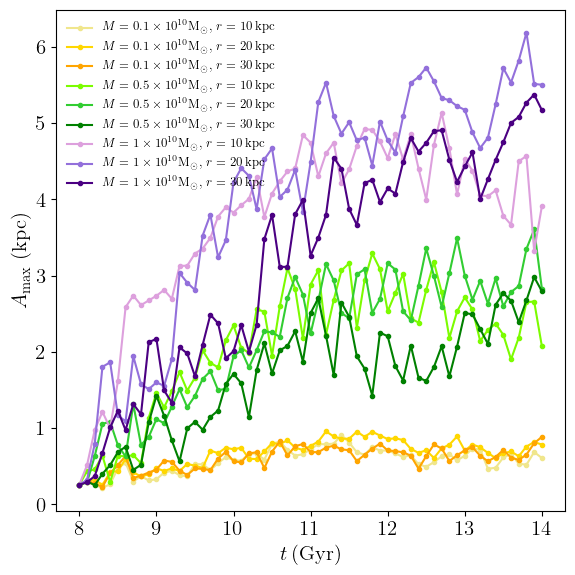

In [11]:
plt.figure(figsize=[6,6])

plt.plot(time_01_10, amplitude_01_10, color='khaki', marker='.',
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_01_20, amplitude_01_20, color='gold', marker='.',
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_01_30, amplitude_01_30, color='orange', marker='.',
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.plot(time_05_10, amplitude_05_10, color='lawngreen', marker='.',
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_05_20, amplitude_05_20, color='limegreen', marker='.',
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_05_30, amplitude_05_30, color='green', marker='.',
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.plot(time_1_10, amplitude_1_10, color='plum', marker='.',
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_1_20, amplitude_1_20, color='mediumpurple', marker='.',
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_1_30, amplitude_1_30, color='indigo', marker='.',
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.legend(frameon=False, fontsize=9)
plt.xlabel('$t \, \mathrm{(Gyr)}$')
plt.ylabel(r'$A_{\rm max}~({\rm kpc})$')
plt.tight_layout()
plt.savefig('amplitudes_max.png')

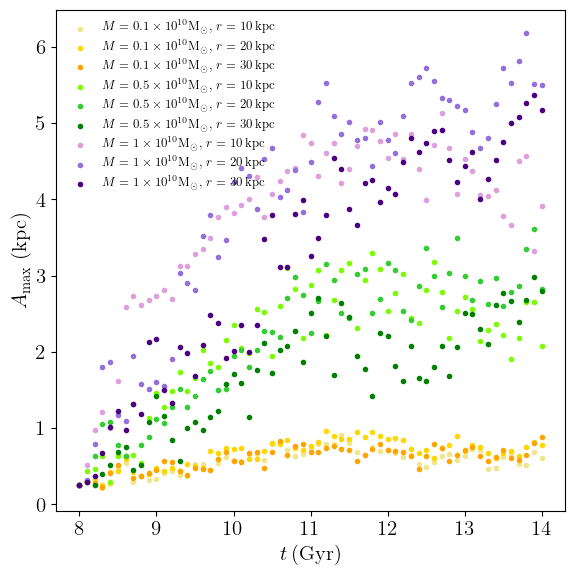

In [13]:
plt.figure(figsize=[6,6])

plt.scatter(time_01_10, amplitude_01_10, color='khaki', marker='.',
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.scatter(time_01_20, amplitude_01_20, color='gold', marker='.',
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.scatter(time_01_30, amplitude_01_30, color='orange', marker='.',
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.scatter(time_05_10, amplitude_05_10, color='lawngreen', marker='.',
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.scatter(time_05_20, amplitude_05_20, color='limegreen', marker='.',
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.scatter(time_05_30, amplitude_05_30, color='green', marker='.',
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.scatter(time_1_10, amplitude_1_10, color='plum', marker='.',
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.scatter(time_1_20, amplitude_1_20, color='mediumpurple', marker='.',
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.scatter(time_1_30, amplitude_1_30, color='indigo', marker='.',
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.legend(frameon=False, fontsize=9)
plt.xlabel('$t \, \mathrm{(Gyr)}$')
plt.ylabel(r'$A_{\rm max}~({\rm kpc})$')
plt.tight_layout()
plt.savefig('amplitudes_max2.png')

In [53]:
#caminhos galáxia + satélite
path_01_10 = 'satelites/nb-sat01-10/'
path_01_20 = 'satelites/nb-sat01-20/'
path_01_30 = 'satelites/nb-sat01-30/'
path_05_10 = 'satelites/nb-sat05-10/'
path_05_20 = 'satelites/nb-sat05-20/'
path_05_30 = 'satelites/nb-sat05-30/'
path_1_10 = 'satelites/nb-sat1-10/'
path_1_20 = 'satelites/nb-sat1-20/'
path_1_30 = 'satelites/nb-sat1-30/'

path_nb = 'n_barrada/'

In [55]:
%%time

amplitude_nb = []

for j in range (0, n_snapshots,2): 
    index = str(j).zfill(3)
    snapshot = path_1_30 + f'snapshot_{index}.hdf5'

    #ler snapshot
    f = h5py.File(snapshot, 'r')

    time = round(f['Header'].attrs['Time'], 2)+ 8.0

    #ler info disco e stars e corrigir posição
    f_disk = f['PartType2']

    x_disk = np.array(f_disk['Coordinates'][:,0])
    y_disk = np.array(f_disk['Coordinates'][:,1])
    z_disk = np.array(f_disk['Coordinates'][:,2])
    m_disk = np.array(f_disk['Masses'])
    vx_disk = np.array(f_disk['Velocities'][:,0])
    vy_disk = np.array(f_disk['Velocities'][:,1])
    vz_disk = np.array(f_disk['Velocities'][:,2])
    Ndisk = len(np.array(f_disk['ParticleIDs']))
                   
    x_new_disk, y_new_disk, z_new_disk = shift_com(m=m_disk, x=x_disk, y=y_disk, z=z_disk)
    vx_new_disk, vy_new_disk, vz_new_disk = shift_com(m_disk, vx_disk, vy_disk, vz_disk)

    theta, phi = theta_phi(N=Ndisk, x=x_new_disk, y=y_new_disk, z=z_new_disk, vx=vx_new_disk,
                           vy=vy_new_disk, vz=vz_new_disk, m=m_disk)
    x_d, y_d, vx_d, vy_d = angular_momentum_1(N=Ndisk, x=x_new_disk, y=y_new_disk, vx=vx_new_disk,
                                      vy=vy_new_disk, theta=theta)
    x_d, z_d, vx_d, vz_d = angular_momentum_2(N=Ndisk, x=x, z=z_new_disk, vx=vx, vz=vz_new_disk, phi=phi)
        
    if j == 0:
        m_star = 0
        x_s = 0
        y_s = 0
        z_s = 0
            
    else:
        f_star = f['PartType4']

        x_star = np.array(f_star['Coordinates'][:,0])
        y_star = np.array(f_star['Coordinates'][:,1])
        z_star = np.array(f_star['Coordinates'][:,2])
        vx_star = np.array(f_star['Velocities'][:,0])
        vy_star = np.array(f_star['Velocities'][:,1])
        vz_star = np.array(f_star['Velocities'][:,2])
        m_star = np.array(f_star['Masses'])
        Nstar = len(np.array(f_star['ParticleIDs']))

        x_new_star, y_new_star, z_new_star = shift_com(m=m_star, x=x_star, y=y_star, z=z_star)
        vx_new_star, vy_new_star, vz_new_star = shift_com(m_star, vx_star, vy_star, vz_star)

        theta_s, phi_s = theta_phi(N=Nstar, x=x_new_star, y=y_new_star, z=z_new_star, vx=vx_new_star,
                                   vy=vy_new_star, vz=vz_new_star, m=m_star)
        x_s, y_s, vx_s, vy_s = angular_momentum_1(N=Nstar, x=x_new_star, y=y_new_star, vx=vx_new_star,
                                              vy=vy_new_star, theta=theta_s)
        x_s, z_s, vx_s, vz_s = angular_momentum_2(N=Nstar, x=x_s, z=z_new_star, vx=vx_s, vz=vz_new_star,
                                                      phi=phi_s)

    #juntar disk + stars
    if j == 0:
        m = m_disk
        x = x_d
        y = y_d
        z = z_d
        
    else:
        m = np.concatenate((m_disk,m_star))
        x = np.concatenate((x_d,x_s))
        y = np.concatenate((y_d,y_s))
        z = np.concatenate((z_d,z_s))

    #cálculo z(theta)
    Theta_nb = []
    Z_nb = []
    
    r = sqrt(x**2 + y**2)
    rmin = 20.0
    rmax = 35.0
    theta_disk = np.arctan2(y, x)
                
    theta_min = (-1) * np.pi
    theta_max = np.pi
    Nbins = 30
    dtheta = (theta_max - theta_min)/Nbins
                
    for i in range(-Nbins, Nbins):
        theta1 = i * dtheta
        theta2 = theta1 + dtheta
        Theta_nb.append((theta1 + theta2) * 0.5)
        cond = argwhere((theta_disk>theta1) & (theta_disk<theta2) & (r>rmin) & (r<rmax)).flatten()
        zmean = mean(z[cond])
        Z_nb.append(zmean)

    #amplitude
    for i in range (0, 60):
    	if math.isnan(Z_nb[i]) == True:
    		Z_nb[i] = 0

    ampmax = np.max(Z_)
    ampmin = abs(np.min(Z_))
    amplitude_nb.append((ampmax + ampmin)/2)
    
    #figura
    # plt.figure(figsize=[6,6])
    # plt.plot(Theta_, Z_, 'k.')
    # xlims=[(-1) * np.pi, np.pi]
    # plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$+\pi/2$', r'$+\pi$'])
    # plt.xlim(xlims)
    # ylims=[-6, 6]
    # plt.ylim(ylims)   
    # plt.xlabel(r'$\theta~$')
    # plt.ylabel(r'$\bar{z}~({\rm kpc})$')
    # plt.title(f'Time = {time} Gyr')
    # plt.tight_layout()
    #plt.savefig(f'z-theta-{time}.png')

ValueError: operands could not be broadcast together with shapes (200000,) (160000,) 

In [ ]:
    # #write to file
    # out    = transpose([Theta_, Z_]) 
    # name = f'z-theta_{j}.txt'
    # savetxt(name, out, fmt='%1.6e')

    # fig, axs = plt.subplots()
    # plt.plot(Theta_, Z_, 'k.')
        
    # xlims=[(-1) * np.pi, np.pi]
    # plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$+\pi/2$', r'$+\pi$'])
    # axs.set_xlim(xlims)
    # ylims=[-6, 6]
    # axs.set_ylim(ylims)
        
    # axs.set_xlabel(r'$\theta~$')
    # axs.set_ylabel(r'$\bar{z}~({\rm kpc})$')
    # axs.set_title(f'Time = {time} Gyr')
        
    # plt.tight_layout()
    # plt.savefig(f'z-theta-b{time}.png')